# Generating faces


In [ ]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Data loader and visualizizing data

In [ ]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [ ]:
# Dataset source: [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)
data_dir = 'processed_celeba_small/'

In [ ]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    
    transform = transforms.Compose(
            [transforms.Resize(image_size),
             transforms.ToTensor()])
       
    celeb_data = datasets.ImageFolder(data_dir, transform=transform)
    
    
    data_loader = torch.utils.data.DataLoader(celeb_data,
                                          batch_size,
                                          shuffle=True)
    return data_loader

In [ ]:
# hyperparameters
batch_size = 256
img_size = 32

# get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

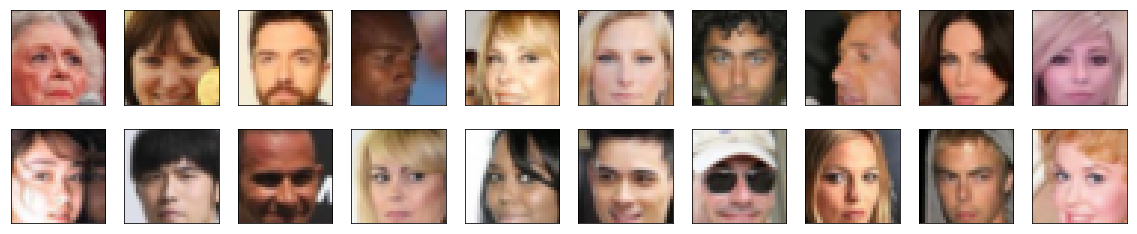

In [ ]:
# display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() 

# plotting
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [ ]:
# scaling pixels
def scale(x, feature_range=(-1, 1)):      
    return x*2 - 1

In [ ]:
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.8824)


# Model


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    
    layers = []
    conv_layer = torch.nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(torch.nn.BatchNorm2d(out_channels))
     
    return torch.nn.Sequential(*layers)

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim = 32):
        
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim
        
        self.conv1 = conv(in_channels = 3,          out_channels = self.conv_dim, kernel_size = 4, batch_norm=False)
        self.conv2 = conv(in_channels = self.conv_dim,   out_channels = self.conv_dim*2, kernel_size = 4)
        self.conv3 = conv(in_channels = self.conv_dim*2, out_channels = self.conv_dim*4, kernel_size = 4)
        
        self.fc = nn.Linear(4*4*self.conv_dim*4, 1)
        

    def forward(self, x):
        
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
            x = x.view(-1, 4*4*self.conv_dim*4)
            x = self.fc(x)
        
        return x

In [ ]:
# deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):

    layers = []
    deconv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)

    layers.append(deconv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
        
    return nn.Sequential(*layers)

In [ ]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):

        super(Generator, self).__init__()

        self.conv_dim = conv_dim
        
        self.fc1 = nn.Linear(z_size, 4*4*self.conv_dim*4)
        self.deconv1 = deconv(in_channels = self.conv_dim*4, out_channels = self.conv_dim*2, kernel_size = 4)
        self.deconv2 = deconv(in_channels = self.conv_dim*2, out_channels = self.conv_dim, kernel_size = 4)
        self.deconv3 = deconv(in_channels = self.conv_dim,   out_channels = 3, kernel_size = 4, batch_norm=False) 
        

    def forward(self, x):
        x = self.fc1(x)
        x = x.view(-1, self.conv_dim*4, 4, 4) #batch size, deconv size, 4, 4)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        x = F.tanh(x)
        
        return x


## Weights initialization

In [ ]:
def weights_init_normal(m):
  
    classname = m.__class__.__name__
    
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        torch.nn.init.normal_(m.weight.data, mean=0.0, std=0.02)  

## Complete network

In [ ]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

#### Hyperparameters

In [ ]:
d_conv_dim = 32
g_conv_dim = 32
z_size = 128

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc1): Linear(in_features=128, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bia

### Network training

In [ ]:
import torch

# GPU Check 
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

In [ ]:
def real_loss(D_out):

    batch_size = D_out.size(0)
    labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    # move labels to GPU if available 
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

In [ ]:
import torch.optim as optim

# params
lr = 0.0002
beta1= 0.5
beta2= 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training & saving samples

In [ ]:
def train(D, G, n_epochs, print_every=50):
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()

    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

                        
            # 1. Train the discriminator
            d_optimizer.zero_grad()
            
            
            # 1.1. real images
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            
            # 1.2. fake images
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # 1.3. add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # 2.1 Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # 2.2 Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # 2.3 perform backprop
            g_loss.backward()
            g_optimizer.step()

            # Loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
        
    #saving models to file

    torch.save(D.state_dict(), 'D_state.pt')
    torch.save(G.state_dict(), 'G_state.pt')
    
    return losses

In [ ]:
#loading Generator and Discriminator models from file
if torch.cuda.is_available():
    D.load_state_dict(torch.load('D_state.pt'))
    G.load_state_dict(torch.load('G_state.pt'))
else:
    D.load_state_dict(torch.load('D_state.pt', map_location='cpu'))
    G.load_state_dict(torch.load('G_state.pt', map_location='cpu'))

In [ ]:
# set number of epochs 
n_epochs = 30

# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   30] | d_loss: 1.1441 | g_loss: 0.7668
Epoch [    1/   30] | d_loss: 1.0148 | g_loss: 0.9293
Epoch [    1/   30] | d_loss: 0.8240 | g_loss: 1.3446
Epoch [    1/   30] | d_loss: 0.9212 | g_loss: 1.3303
Epoch [    1/   30] | d_loss: 0.9241 | g_loss: 1.3541
Epoch [    1/   30] | d_loss: 0.9499 | g_loss: 0.8131
Epoch [    1/   30] | d_loss: 0.9912 | g_loss: 1.1845
Epoch [    1/   30] | d_loss: 0.9883 | g_loss: 2.2217
Epoch [    2/   30] | d_loss: 1.8253 | g_loss: 2.8005
Epoch [    2/   30] | d_loss: 0.9752 | g_loss: 1.1950
Epoch [    2/   30] | d_loss: 1.0356 | g_loss: 1.8686
Epoch [    2/   30] | d_loss: 1.2192 | g_loss: 0.9256
Epoch [    2/   30] | d_loss: 0.8196 | g_loss: 1.1610
Epoch [    2/   30] | d_loss: 0.9812 | g_loss: 0.8722
Epoch [    2/   30] | d_loss: 0.8939 | g_loss: 1.3397
Epoch [    2/   30] | d_loss: 0.8019 | g_loss: 1.1161
Epoch [    3/   30] | d_loss: 0.9860 | g_loss: 0.8132
Epoch [    3/   30] | d_loss: 0.8624 | g_loss: 1.5120
Epoch [    3/   30] | d_loss

## Training loss plot

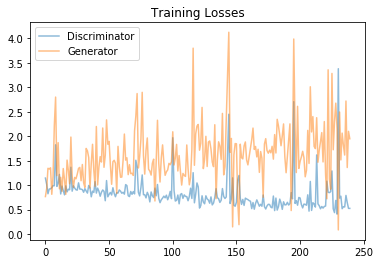

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Samples from training


In [ ]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [ ]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

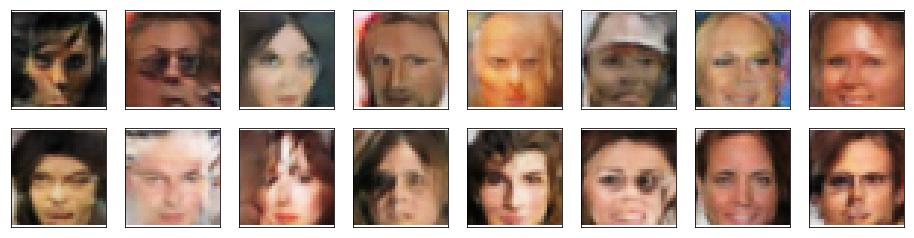

In [ ]:
_ = view_samples(-1, samples)

### after 1 epoch
![image.png](attachment:image.png)

### after 6 epoch
![image.png](attachment:image.png)

### after 16 epoch
![image.png](attachment:image.png)

### after 46 epochs
![image.png](attachment:image.png)

### after 47 epochs
![image.png](attachment:image.png)

### images from dataset for comparision
![image.png](attachment:image.png)

# Summary

Generated images look like faces but they are deformed or have mixed features (e.g. left side of face is different from right).  
There is only little improvement from epoch 16 to epoch 46.
No noticeable improvement from epoch 46 to 47. We can even access that samples from epoch 46 are more realistic.

I reduced learning rate to lr=0.0002 but this helped only partially.  

As we see from losses graph discriminator do better job than generator.
We can change architecture of generator with addit additional convulutional layers. This could improve quality of generated faces.
![image.png](attachment:image.png)

If we would like to use this generator as random people generator we have be aware of strong bias in dataset that doesn't correspond to world population.